In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import matplotlib.animation as animation
from matplotlib import rc
%matplotlib notebook

## Funcionamento do Programa

`three_bp()` $\rightarrow$ `output_3bp.txt` $\rightarrow$ `simul3bp()`

## Engine Física


Num problema de N corpos, para um dado referencial e em um sistema isolado, a soma da energia cinética $E_K = \sum\limits_{i} \frac{1}{2} m_i v_i ^2$ e da energia potencial gravitacional $U = - G \sum\limits_{i, j \neq i} \frac{m_i m_j}{r_{ij}}$ nos dá a energia total, $E_T = E_K + U$, que deve ser constante. Além disso, o vetor momento angular $\vec{L} = \sum\limits_{i} \vec{r}_i \times \vec{p}_i$ com relação a algum ponto fixo do sistema, deve também ser constante. 

O problema de N corpos é um sistema de EDOs lineares de segunda ordem. Resolvê-lo numericamente significa resolver EDOs de primeira ordem, mas duas vezes!

\begin{equation}
    \begin{cases}
      \frac{d \vec{r_i}}{d t} = \frac{\vec{p_i}}{m_i}\\
      \frac{d \vec{p}_i}{dt} = \vec{F_i}
    \end{cases}
\end{equation}


In [2]:
def stability(r1, r2, r3, p1, p2, p3, m1, m2, m3):
    '''
    Analisa a estabilidade do nosso método pelas 
        grandezas físicas energia total e momento angular.
    '''
    G = 5  #cte de Gravitaçao Universal (proporcionalidade)
    epsilon = 1.E-8 #cte para estabilidade
    
    dist12 = np.linalg.norm(r1 - r2) + epsilon
    dist13 = np.linalg.norm(r1 - r3) + epsilon
    dist23 = np.linalg.norm(r2 - r3) + epsilon
    U = - G * (m1 * m2 / (dist12 + epsilon) + m1 * m3 / (dist13 + epsilon) + m2 * m3 / (dist23 + epsilon))
    Ek = np.linalg.norm(p1) ** 2 / (m1 * 2.) + np.linalg.norm(p2) ** 2 / (m2 * 2.) + np.linalg.norm(p3) ** 2 / (m3 * 2.)  # Ek = 1/2 * mv^2
    Et = Ek + U
    
    nr1 = np.linalg.norm(r1) + epsilon
    np1 = np.linalg.norm(p1) + epsilon
    theta1 = math.acos(np.dot(r1 / nr1 , p1 / np1))
    l1 = nr1 * np1 * math.sin(theta1)

    nr2 = np.linalg.norm(r2) + epsilon
    np2 = np.linalg.norm(p2) + epsilon
    theta2 = math.acos(np.dot(r2 / nr2 , p2 / np2))
    l2 = nr2 * np2 * math.sin(theta2)
    
    nr3 = np.linalg.norm(r3) + epsilon
    np3 = np.linalg.norm(p3) + epsilon
    theta3 = math.acos(np.dot(r3 / nr3 , p3 / np3))
    l3 = nr3 * np3 * math.sin(theta3)

    L = l1 + l2 + l3
    
    return Et, L

def force(ra, rb, ma, mb):#pronto
    '''
    Retorna a força gravitacional que 2 causa em 1
    (1)---->   (2)
    '''
    G = 5  #cte de Gravitaçao Universal (proporcionalidade)
    epsilon = 1.E-8 #cte para estabilidade
    
    rab = rb - ra
    dist = np.linalg.norm(rab)

    return (G * ma * mb / (epsilon + dist ** 3)) * rab

## Métodos Numéricos

In [3]:
def euler(p, r, m, F, dt):#pronto
    '''
    Usa método de Euler para atualizar a posição
        das partículas.
    '''
    p += F * dt  # 2a Lei de Newton: F*dt = dp 
    r += p / m * dt # equação problema: d2r/dt2 = Gm/r^2
    return p, r

In [4]:
def three_bp(r1, r2, r3, p1, p2, p3, m1, m2, m3):    
    # Centralizar simulação no centro de massa
    rcm = (m1*r1 + m2*r2 + m3*r3) / (m1 + m2 + m3)

    r1 -= rcm
    r2 -= rcm
    r3 -= rcm

    vcm = (p1 + p2 + p3) / (m1 + m2 + m3)

    p1 -= m1 * vcm
    p2 -= m2 * vcm
    p3 -= m3 * vcm

    # Pedimos ao usurário
    tf = float(input("duração da simulação (seg): ")) 
    t = 0.
    N = int(input("número de iterações: "))
    delta_t = tf/N  # timestep
    print("timestep =", delta_t)
    metodo = int(input("escolha o método: "))

    file = open('output_3bp.txt', 'w')

    stopwatch = time.time() # para análise de desempenho

    # Escreve em output a Duração, o número de Iterações e o método
    while t < tf: # enquanto durar a simulação
        F21 = force(r1, r2, m1, m2)
        F31 = force(r1, r3, m1, m3)
        F32 = force(r2, r3, m2, m3)

        F1 =  F21 + F31
        F2 = -F21 + F32
        F3 = -F31 - F32

        # Atualiza as posições dos dois objetos
        # Método 1: Euler
        if metodo == 1:
            p1, r1 = euler(p1, r1, m1, F1, delta_t)
            p2, r2 = euler(p2, r2, m2, F2, delta_t)  # 3a Lei de Newton: F12 = -F21
            p3, r3 = euler(p3, r3, m3, F3, delta_t)

        # Método 2: Euler modificado (Runge-Kutta, O[2])
        if metodo == 2:
            F21 = force(r1, r2, m1, m2)
            F31 = force(r1, r3, m1, m3)
            F32 = force(r2, r3, m2, m3)
            F1 =  F21 + F31
            F2 = -F21 + F32  # 3a Lei de Newton: F12 = -F21
            F3 = -F31 - F32

            kp1, kr1 = euler(p1, r1, m1, F1, delta_t)
            kp2, kr2 = euler(p2, r2, m2, F2, delta_t)
            kp3, kr3 = euler(p3, r3, m3, F3, delta_t)
            # passo de aproximação de euler:
            F21 = force(kr1, kr2, m1, m2)
            F31 = force(kr1, kr3, m1, m3)
            F32 = force(kr2, kr3, m2, m3)
            # no euler modificado, faz-se uma média:
            F1 =  F21 + F31
            F2 = -F21 + F32  # 3a Lei de Newton: F12 = -F21
            F3 = -F31 - F32
            # Uma maneira de se fazer a conta usando a função euler()
            p1 = 0.5 * (euler(p1, r1, m1, F1, delta_t)[0] + kp1)
            p2 = 0.5 * (euler(p2, r2, m2, F2, delta_t)[0] + kp2)
            p3 = 0.5 * (euler(p3, r3, m3, F3, delta_t)[0] + kp3)
            r1 = 0.5 * (euler(p1, r1, m1, F1, delta_t)[1] + kr1)
            r2 = 0.5 * (euler(p2, r2, m2, F2, delta_t)[1] + kr2)
            r3 = 0.5 * (euler(p3, r3, m3, F3, delta_t)[1] + kr3)
        
        if metodo == 3:
            # kXpY em que X é a ordem k de 'estagio' do método e Y refere-se à partícula.
            k1p1 = F1  # dp/dt = F; no nosso caso, a força grav é a "função f"
            k1r1 = (p1/m1) # k de primeira ordem da posição (r) da partícula 1. #kr's ainda estranhos, olhar
            k1p2 = F2
            k1r2 = (p2/m2)
            k1p3 = F3
            k1r3 = (p3/m3)

            k2p1 = force(r1 + (0.5)*delta_t*k1r1, r2 + (0.5)*delta_t*k1r2, m1, m2) + force(r1 + (0.5)*delta_t*k1r1, r3 + (0.5)*delta_t*k1r3, m1, m3)
            k2r1 = (p1 + k2p1*(0.5)*(delta_t))/m1
            k2p2 = -force(r1 + (0.5)*delta_t*k1r1, r2 + (0.5)*delta_t*k1r2, m1, m2) + force(r2 + (0.5)*delta_t*k1r2, r3 + (0.5)*delta_t*k1r3, m2, m3)
            k2r2 = (p2 + k2p2*(0.5)*(delta_t))/m2
            k2p3 = -force(r1 + (0.5)*delta_t*k1r1, r3 + (0.5)*delta_t*k1r3, m1, m3) - force(r2 + (0.5)*delta_t*k1r2, r3 + (0.5)*delta_t*k1r3, m2, m3)
            k2r3 = (p3 + k2p3*(0.5)*(delta_t))/m3

            k3p1 = force(r1 + (0.5)*delta_t*k2r1, r2 + (0.5)*delta_t*k2r2, m1, m2) + force(r1 + (0.5)*delta_t*k2r1, r3 + (0.5)*delta_t*k2r3, m1, m3)
            k3r1 = (p1 + k3p1*(0.5)*(delta_t))/m1
            k3p2 = -force(r1 + (0.5)*delta_t*k2r1, r2 + (0.5)*delta_t*k2r2, m1, m2) + force(r2 + (0.5)*delta_t*k2r2, r3 + (0.5)*delta_t*k2r3, m2, m3)
            k3r2 = (p2 + k3p2*(0.5)*(delta_t))/m2
            k3p3 = -force(r1 + (0.5)*delta_t*k2r1, r3 + (0.5)*delta_t*k2r3, m1, m3) - force(r2 + (0.5)*delta_t*k2r2, r3 + (0.5)*delta_t*k2r3, m2, m3)
            k3r3 = (p3 + k3p3*(0.5)*(delta_t))/m3

            k4p1 = force(r1 + delta_t*k3r1, r2 + delta_t*k3r2, m1, m2) + force(r1 + delta_t*k3r1, r3 + delta_t*k3r3, m1, m3)
            k4r1 = (p1 + k4p1*(delta_t))/m1
            k4p2 = -force(r1 + delta_t*k3r1, r2 + delta_t*k3r2, m1, m2) + force(r2 + delta_t*k3r2, r3 + delta_t*k3r3, m2, m3)
            k4r2 = (p2 + k4p2*(delta_t))/m2
            k4p3 = -force(r1 + delta_t*k3r1, r3 + delta_t*k3r3, m1, m3) - force(r2 + delta_t*k3r2, r3 + delta_t*k3r3, m2, m3)
            k4r3 = (p3 + k4p3*(delta_t))/m3
        
            p1 += (delta_t/6.) * (k1p1 + 2*k2p1 + 2*k3p1 + k4p1)
            r1 += (delta_t/6.) * (k1r1 + 2*k2r1 + 2*k3r1 + k4r1) 
            p2 += (delta_t/6.) * (k1p2 + 2*k2p2 + 2*k3p2 + k4p2)
            r2 += (delta_t/6.) * (k1r2 + 2*k2r2 + 2*k3r2 + k4r2) 
            p3 += (delta_t/6.) * (k1p3 + 2*k2p3 + 2*k3p3 + k4p3)
            r3 += (delta_t/6.) * (k1r3 + 2*k2r3 + 2*k3r3 + k4r3)
            
        Et, L = stability(r1, r2, r3, p1, p2, p3, m1, m2, m3)

        file.write('%f %f %f %f %f %f %f %f %f\n' %(t, Et, L, r1[0], r1[1], r2[0], r2[1], r3[0], r3[1])) # imprime t, Et, L, r1, r2

        t += delta_t

    print("elapsed time(sec): ", time.time()-stopwatch)
    file.close()

## Seleção de Condições Iniciais

In [5]:
def conditions(n):
    if n == 1:
        # Sistema que explode:
        # condições iniciais:
        r1 = np.array([0., 0.]) # vetor posição [x, y]
        r2 = np.array([100., 50.])
        r3 = np.array([50., 100.])

        p1 = np.array([10., 0.]) # vetor momento [px, py]
        p2 = np.array([0., 0.])
        p3 = np.array([0., -10.])

        m1 = 10
        m2 = 10
        m3 = 10
        
        dur = 150 # duração da simulação (seg)
        it = 2000 # número de iterações
        met = 1 # método: 1
        
    elif n == 2:
        # explode forte
        # condições iniciais:
        r1 = np.array([0., 0.]) # vetor posição [x, y]
        r2 = np.array([-50., -50.])
        r3 = np.array([50., 50.])

        p1 = np.array([ 0., 0.]) # vetor momento [px, py]
        p2 = np.array([ 0., 10.])
        p3 = np.array([0., -10.])

        m1 = 10
        m2 = 10
        m3 = 10
        
        dur = 1000
        it = 40000
        met = 1

    elif n == 3:
        # três corpos sincronizados
        # condições iniciais:
        r1 = np.array([-50, -100*np.sqrt(3)/6]) # vetor posição [x, y]
        r2 = np.array([ 50.,-100*np.sqrt(3)/6])
        r3 = np.array([  0., 100*np.sqrt(3)/3])

        p1 = np.array([0.5/2,-0.5*np.sqrt(3)/2]) # vetor momento [px, py]
        p2 = np.array([0.5/2,0.5*np.sqrt(3)/2])
        p3 = np.array([ -0.5, 0.])

        m1 = 5
        m2 = 5
        m3 = 5

        dur = 1000
        it = 10000
        met = 1

    elif n == 4:
        # "Sistema solar"
        # condições iniciais:
        r1 = np.array([0., 0.]) # vetor posição [x, y]
        r2 = np.array([ 100., 0.])
        r3 = np.array([-100., 0,])

        p1 = np.array([  0. , 0.]) # vetor momento [px, py]
        p2 = np.array([ 0., 11.])
        p3 = np.array([ 0., 10.])

        m1 = 1000
        m2 = 2
        m3 = 2

        dur = 200
        it = 2000
        met = 1
        
    elif n == 5:
        # Sistema bem elíptico
        # condições iniciais:
        r1 = np.array([0., 0.]) # vetor posição [x, y]
        r2 = np.array([ 100., 0.])
        r3 = np.array([ 110., 0])

        p1 = np.array([  0. , 0.]) # vetor momento [px, py]
        p2 = np.array([ 0., 8.])
        p3 = np.array([ 0., 8.])

        m1 = 1000
        m2 = 2
        m3 = 1

        dur = 200
        it = 2000
        met = 1
        
    elif n == 6:
        # Figura em 8 (aproximada)
        # condições iniciais:
        alfa = 0.749442191
        beta = 1.150178899
        r1 = np.array([0., 0.]) # vetor posição [x, y]
        r2 = np.array([ 100., 0.])
        r3 = np.array([-100., 0])

        p1 = np.array([alfa, beta]) # vetor momento [px, py]
        p2 = np.array([-alfa/2, -beta/2]) # Condições de Montgomery: v2 = v3 = -0.5*v1
        p3 = np.array([-alfa/2, -beta/2])

        m1 = 2.85
        m2 = 2.85
        m3 = 2.85

        dur = 4000
        it = 10000
        met = 1
        
    print("Recomendações de execução:")
    print("duração da simulação (seg):", dur)
    print("número de iterações:", it)
    print("método:", met, "\n")
    
    three_bp(r1, r2, r3, p1, p2, p3, m1, m2, m3)

## Em uma conferência no ano de 2000, Alain Chenciner e Richard Montgomery demonstraram uma incrível solução para o problema de três corpos: uma órbita estável em formato de 8!
Chenciner, A. and Montgomery, R., 2000. A Remarkable Periodic Solution of the Three-Body Problem in the Case of Equal Masses. The Annals of Mathematics, 152(3), p.881.

In [6]:
conditions(6)

Recomendações de execução:
duração da simulação (seg): 4000
número de iterações: 10000
método: 1 

duração da simulação (seg): 4000
número de iterações: 15000
timestep = 0.26666666666666666
escolha o método: 3
elapsed time(sec):  9.853063583374023


## Simul3bp

<IPython.core.display.Javascript object>


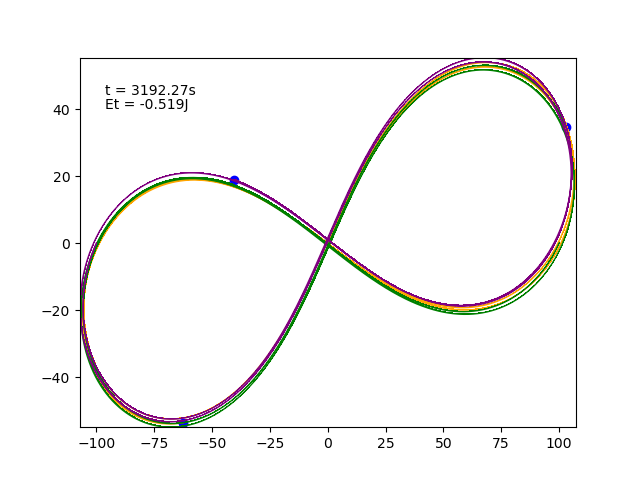

In [7]:
# carregar variáveis
file = "output_3bp.txt"
paths = np.loadtxt(file)

# Propriedades do sistema
t = paths[:,0]
Et= paths[:,1]
L = paths[:,2]

# Posições das partículas
x = paths[:,[3,5,7]]
y = paths[:,[4,6,8]]

# inicia a figura e os objetos
fig = plt.figure()
ax = plt.axes(xlim=(np.min(x), np.max(x)), ylim=(np.min(y), np.max(y)))

mat, = ax.plot([], [], 'o', color='blue')
cm,  = ax.plot([], [], 'x', color='grey')
trace1, = ax.plot([], [], ',-', lw=1, color = 'orange')
trace2, = ax.plot([], [], ',-', lw=1, color = 'green')
trace3, = ax.plot([], [], ',-', lw=1, color = 'purple')

# Imprimir os textos na animação:
t_template = 't = %.2fs'
t_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

Et_template = 'Et = %.3fJ'
Et_text = ax.text(0.05, .86, '', transform=ax.transAxes)

L_template = r'L = %.3f$kgm^2/s$'
L_text = ax.text(0.05, 0.82, '', transform=ax.transAxes)

# toma o número de frames da animação a partir do tamanho do arquivo
frames = paths.shape[0]

history_x1, history_y1 = [], []
history_x2, history_y2 = [], []
history_x3, history_y3 = [], []
#line, = ax.plot([], [], 'o-', lw=1)

def init():
    mat.set_data([], [])
    cm.set_data(0,0)
    trace1.set_data([],[])
    trace2.set_data([],[])
    trace3.set_data([],[])
    return mat, cm, trace1, trace2, trace3

def animate(i):
    pos_x = x[i]
    pos_y = y[i]
    mat.set_data(pos_x, pos_y) 
    cm.set_data(0,0)
    
    if len(history_x1) < frames:

        history_x1.append(pos_x[0])
        history_y1.append(pos_y[0])

        history_x2.append(pos_x[1])
        history_y2.append(pos_y[1])

        history_x3.append(pos_x[2])
        history_y3.append(pos_y[2])
    
    trace1.set_data(history_x1, history_y1)
    trace2.set_data(history_x2, history_y2)
    trace3.set_data(history_x3, history_y3)
        
    # Texto da animação
    t_text.set_text(t_template % (t[i]))
    Et_text.set_text(Et_template % (Et[i]))
    L_text.set_text(L_template % (L[i]))
    
    return mat, cm, trace1, trace2, trace3, t_text, Et_text, L_text

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=2, blit=True)

plt.show()